# Create a climatology with different data source
In this notebook we create a climatology for the region of interest, using observations from the Beacon services.
Once data are downloaded, a duplicate removal is applied.
Finally, the gridded fields are created with DIVAnd software tool.

In [1]:
using HTTP
using JSON3
using Dates
using NCDatasets
using Colors
using Makie
using OrderedCollections
using CairoMakie
using GeoMakie
using DIVAnd
using Random
using Downloads
using JupyterFormatter
include("./DIVAndFairEase.jl")
enable_autoformat()

1-element Vector{Function}:
 format_current_cell (generic function with 1 method)

<div class="alert alert-block alert-info">
Here the API token is stored as an environment variable.
It is also possible to store it in a local file. 
</div>

In [2]:
token = ENV["beaconAPItoken"];

## 🪛 Configuration
Set the region and the variable of interest.   
The variable `datasourcelist` contains the `Beacon` instances that will be used for the data queries.

In [3]:
regionname = "North_Adriatic"
doplot = true

const varname = "sea_water_temperature"
const lonname = "longitude"
const latname = "latitude"
const timename = "datetime"
const depthname = "depth"

datasourcelist = [
    "Euro-Argo",
    "CORA Profile",
    "CORA Timeseries",
    "World Ocean Database",
    "SeaDataNet CDI TS",
];

### 📁📁 Create directories

In [4]:
datadir = joinpath("../data/", regionname)
outputdir = joinpath("../output/testQC", regionname)
figdir = joinpath("../figures/", regionname)
mkpath.([datadir, outputdir, figdir]);

### 🗺️ Spatial extent
The bounding box is set according to the region name.

In [5]:
domaininfo = Dict(
    "North_Adriatic" => [12.0, 18.0, 43.0, 46.0],
    "Arctic_region" => [-44.25, 70.0, 56.5, 83.0],
    "North_East_Atlantic" => [-42.0, -0.1, 24.9, 48.0],
    "Baltic_Sea" => [9.4, 30.9, 53.0, 65.9],
    "Black_Sea" => [26.5, 41.95, 40.0, 47.95],
    "Mediterranean_Sea" => [-7.0, 36.375, 30.0, 45.875],
    "North_Sea" => [-100.0, 50.0, -80.0, 80.0],
    "Canary_Islands" => [-20.0, -9.0, 25.0, 31.5],
    "World_Ocean" => [-180.0, 180.0, -90.0, 90.0],
);

### 📆 Depth and time ranges

In [111]:
mindepth = 0.0 #Minimum water depth
maxdepth = 1000.0 #Maximum water depth
datestart = DateTime(2010, 1, 1)
dateend = DateTime(2024, 12, 31)

2024-12-31T00:00:00

### Prepare queries and download data
The observations are saved as netCDF files (one per data source),      
so that they can be later re-used.
<div class="alert alert-block alert-info">
It is also possible to get the data in other formats such as <code>Parquet</code>,  <code>ODV</code> or <code>Arrow IPC</code>.
</div>

### Euro-Argo

In [34]:
datasource = "Euro-Argo"
minlon = domaininfo[regionname][1]
maxlon = domaininfo[regionname][2]
minlat = domaininfo[regionname][3]
maxlat = domaininfo[regionname][4]

queryparams = [
    OrderedDict(
        "column_name" => "TEMP_ADJUSTED",
        "alias" => "$(varname)",
        "skip_fill_values" => true,
    ),
    OrderedDict(
        "column_name" => "TEMP_ADJUSTED_QC",
        "alias" => "$(varname)_QC",
        "skip_fill_values" => true,
    ),
    OrderedDict("column_name" => "TEMP_ADJUSTED_QC.long_name"),
    OrderedDict("column_name" => "TEMP_ADJUSTED_QC.conventions"),
    OrderedDict("column_name" => "JULD", "alias" => "$(timename)"),
    OrderedDict("column_name" => "PRES", "alias" => "$(depthname)"),
    OrderedDict("column_name" => "LONGITUDE", "alias" => "$(lonname)"),
    OrderedDict("column_name" => "LATITUDE", "alias" => "$(latname)"),
]

filters = [
    OrderedDict(
        "for_query_parameter" => "datetime",
        "min" => Dates.format(datestart, "yyyy-mm-ddT00:00:00"),
        "max" => Dates.format(dateend, "yyyy-mm-ddT00:00:00"),
    ),
    OrderedDict(
        "for_query_parameter" => "$(depthname)",
        "min" => mindepth,
        "max" => maxdepth,
    ),
    OrderedDict("for_query_parameter" => "$(lonname)", "min" => minlon, "max" => maxlon),
    OrderedDict("for_query_parameter" => "$(latname)", "min" => minlat, "max" => maxlat),
]

paramdict = OrderedDict(
    "query_parameters" => queryparams,
    "filters" => filters,
    "output" => Dict("format" => "netcdf"),
)
query = JSON3.write(paramdict);
query

"{\"query_parameters\":[{\"column_name\":\"TEMP_ADJUSTED\",\"alias\":\"sea_water_temperature\",\"skip_fill_values\":true},{\"column_name\":\"TEMP_ADJUSTED_QC\",\"alias\":\"sea_water_temperature_QC\",\"skip_fill_values\":true},{\"column_name\":\"TEMP_ADJUSTED_QC.long_name\"},{\"column_name\":\"TEMP_AD" ⋯ 232 bytes ⋯ "\":\"datetime\",\"min\":\"1960-01-01T00:00:00\",\"max\":\"2024-12-31T00:00:00\"},{\"for_query_parameter\":\"depth\",\"min\":0.0,\"max\":1000.0},{\"for_query_parameter\":\"longitude\",\"min\":12.0,\"max\":18.0},{\"for_query_parameter\":\"latitude\",\"min\":43.0,\"max\":46.0}],\"output\":{\"format\":\"netcdf\"}}"

In [35]:
# Construct file and figure names
filename = joinpath(outputdir, "$(datasource).nc")
isfile(filename) ? rm(filename) : @debug("ok")
# Write the data in netCDF files
@info("Data will be written in file:\n$(filename)")
if isfile(filename)
    @info("File already downloaded")
else
    @time open(filename, "w") do io
        r = HTTP.request(
            "POST",
            joinpath(DIVAndFairEase.beacon_services[datasource], "api/query"),
            ["Content-type" => "application/json", "Authorization" => "Bearer $(token)"],
            query,
            response_stream = io,
        )
        @info(r.status)
    end

    NCDataset(filename, "a") do ds
        ds.attrib["data_source"] = datasource
        ds.attrib["date_created"] = Dates.format(Dates.now(), "yyyy-mm-ddTHH:MM:SS")
        # Maybe add other attributes
    end
end

┌ Info: Data will be written in file:
└ ../output/testQC/North_Adriatic/Euro-Argo.nc


  9.106977 seconds (48.84 k allocations: 8.317 MiB, 2 lock conflicts, 0.29% compilation time)


[ Info: 200


"2025-06-25T11:35:13"

## Load the QC

In [62]:
ds = NCDataset(filename, "r")
varQC = coalesce.(ds["$(varname)_QC"][:], "9") # replace "missing" with "9" 
gooddata = findall((varQC .== "1") .| (varQC .== "2"))
obslon = ds["$(lonname)"][gooddata]
obslat = ds["$(latname)"][gooddata]
obsdepth = ds["$(depthname)"][gooddata]
obstime = ds["$(timename)"][gooddata]
obsval = coalesce.(ds["$(varname)"][gooddata], NaN)
close(ds)

closed Dataset

In [63]:
length(findall(ismissing.(varQC)))

0

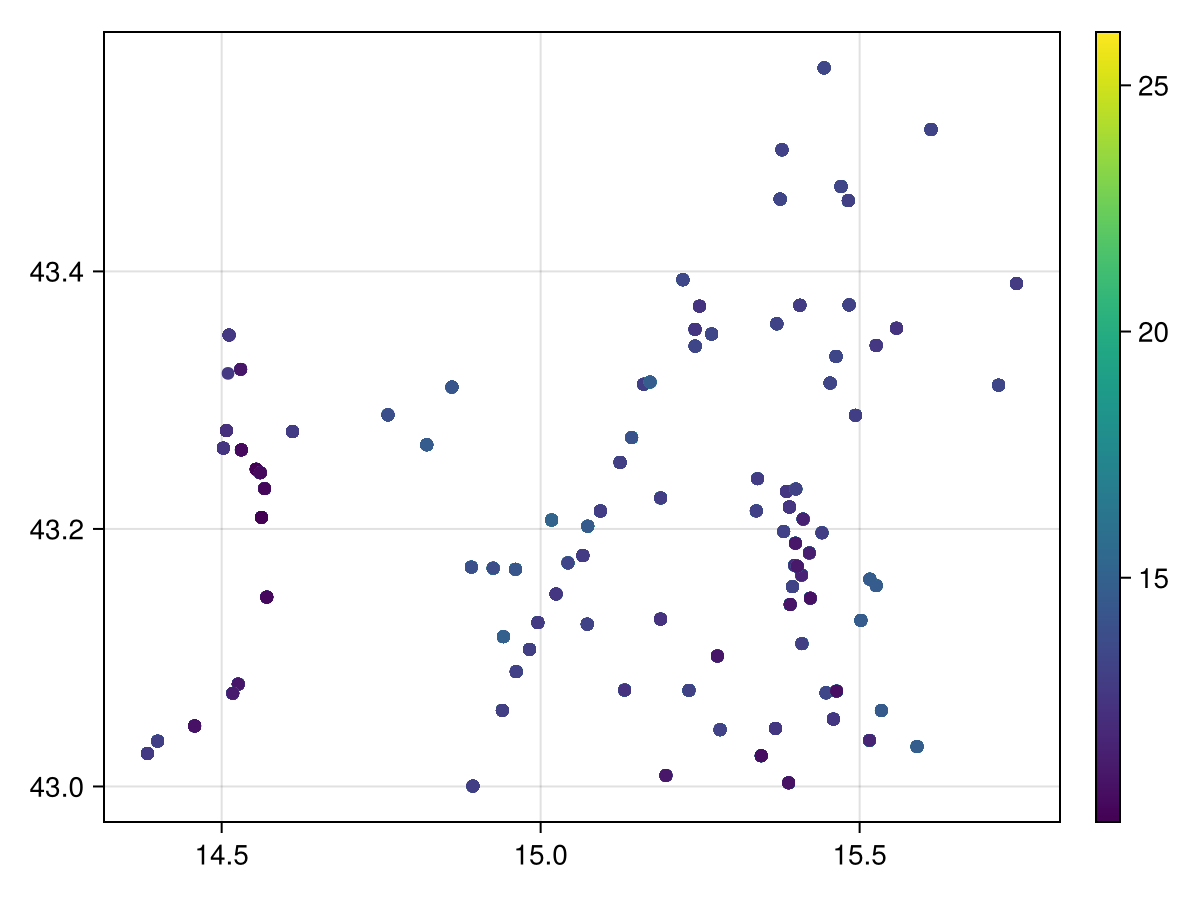

In [68]:
fig = Figure()
ax = Axis(fig[1, 1])
sc = scatter!(ax, obslon, obslat, color = obsval)
Colorbar(fig[1, 2], sc)
fig

### SeaDataNet

In [112]:
datasource = "SeaDataNet CDI TS"

queryparams = [
    OrderedDict(
        "column_name" => "TEMPPR01",
        "alias" => "$(varname)",
        "skip_fill_values" => true,
    ),
    #OrderedDict(
    #    "column_name" => "TEMPPR01_SEADATANET_QC",
    #    "alias" => "$(varname)_QC",
    #    "skip_fill_values" => true,
    #),
    #OrderedDict("column_name" => "TEMPPR01_SEADATANET_QC.long_name"),
    #OrderedDict("column_name" => "TEMPPR01_SEADATANET_QC.conventions"),
    OrderedDict("column_name" => "TIME"), #"alias" => "$(timename)"),
    OrderedDict("column_name" => "DEPTH"), #"alias" => "$(depthname)"),
    OrderedDict("column_name" => "LONGITUDE"),# "alias" => "$(lonname)"),
    OrderedDict("column_name" => "LATITUDE"),# "alias" => "$(latname)"),
]

filters = [
    OrderedDict(
        "for_query_parameter" => "TIME",
        "min" => Dates.format(datestart, "yyyy-mm-ddT00:00:00"),
        "max" => Dates.format(dateend, "yyyy-mm-ddT00:00:00"),
    ),
    OrderedDict("for_query_parameter" => "DEPTH", "min" => mindepth, "max" => maxdepth),
    OrderedDict("for_query_parameter" => "LONGITUDE", "min" => minlon, "max" => maxlon),
    OrderedDict("for_query_parameter" => "LATITUDE", "min" => minlat, "max" => maxlat),
]

paramdict = OrderedDict(
    "query_parameters" => queryparams,
    "filters" => filters,
    "output" => Dict("format" => "netcdf"),
)
query = JSON3.write(paramdict);
query

"{\"query_parameters\":[{\"column_name\":\"TEMPPR01\",\"alias\":\"sea_water_temperature\",\"skip_fill_values\":true},{\"column_name\":\"TIME\",\"alias\":\"datetime\"},{\"column_name\":\"DEPTH\",\"alias\":\"depth\"},{\"column_name\":\"LONGITUDE\",\"alias\":\"longitude\"},{\"column_name\":\"LATITUDE\",\"alias\":\"la" ⋯ 37 bytes ⋯ "meter\":\"TIME\",\"min\":\"2010-01-01T00:00:00\",\"max\":\"2024-12-31T00:00:00\"},{\"for_query_parameter\":\"DEPTH\",\"min\":0.0,\"max\":1000.0},{\"for_query_parameter\":\"LONGITUDE\",\"min\":12.0,\"max\":18.0},{\"for_query_parameter\":\"LATITUDE\",\"min\":43.0,\"max\":46.0}],\"output\":{\"format\":\"netcdf\"}}"

In [115]:
# Construct file and figure names
filename = joinpath(outputdir, "$(replace(datasource, " "=>"_")).nc")
isfile(filename) ? rm(filename) : @debug("ok")
beaconURL = joinpath(DIVAndFairEase.beacon_services[datasource], "api/query")
@info("Getting data from $(beaconURL)");

# Write the data in netCDF files
@info("Data will be written in file:\n$(filename)")
if isfile(filename)
    @info("File already downloaded")
else
    @time open(filename, "w") do io
        r = HTTP.request(
            "POST",
            beaconURL,
            ["Content-type" => "application/json", "Authorization" => "Bearer $(token)"],
            query,
            response_stream = io,
        )
        @info(r.status)
    end

    NCDataset(filename, "a") do ds
        ds.attrib["data_source"] = datasource
        ds.attrib["date_created"] = Dates.format(Dates.now(), "yyyy-mm-ddTHH:MM:SS")
        # Maybe add other attributes
    end
end

[ Info: Getting data from https://beacon-cdi.maris.nl/api/query
┌ Info: Data will be written in file:
└ ../output/testQC/North_Adriatic/SeaDataNet_CDI_TS.nc


LoadError: HTTP.Exceptions.StatusError(400, "POST", "/api/query", HTTP.Messages.Response:
"""
HTTP/1.1 400 Bad Request
Content-Type: application/json
Server: Microsoft-IIS/10.0
X-Powered-By: ARR/3.0, ASP.NET
Date: Wed, 25 Jun 2025 20:42:57 GMT
Content-Length: 119
Set-Cookie: ******

[Message Body was streamed]""")

In [110]:
joinpath(DIVAndFairEase.beacon_services[datasource], "api/query")

"https://beacon-cdi.maris.nl/api/query"